In [7]:
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
import pickle

In [3]:
import pandas as pd
admission_table=pd.read_csv('data/ADMISSIONS.csv')
notes_table=pd.read_csv('data/NOTEEVENTS.csv')
data_merged = pd.merge(notes_table, admission_table, how='left', on=['SUBJECT_ID', 'HADM_ID'])

In [83]:
notes_table_useful = notes_table[notes_table['SUBJECT_ID'].isin(valid_sub_final)]
notes_table_useful['CHARTTIME']= [parser.parse(x) if type(x)!=float else x for x in notes_table_useful['CHARTTIME']]
notes_table_useful['CHARTTIME'] = pd.to_datetime(notes_table_useful['CHARTTIME'])
print('DEATHTIME')

/Users/apple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


DEATHTIME


/Users/apple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [4]:
valid_subject = pd.read_csv('data/id_inhospital_deathtime.csv', index_col = 0)

In [ ]:
# take the first addmission time 
admission_table['ADMITTIME']=admission_table['ADMITTIME'].map(lambda x: parser.parse(x))
sub_hops_admission = admission_table.groupby(['SUBJECT_ID'])['ADMITTIME'].unique()
sub_hops_admission = sub_hops_admission.map(lambda x: sorted(x)[0])

In [ ]:
first_adm = pd.DataFrame({'SUBJECT_ID': sub_hops_admission.index,'ADMITTIME':sub_hops_admission.values })
first_adm = pd.merge(first_adm, admission_table, how = 'left', on = ['SUBJECT_ID','ADMITTIME' ] )
id_first = set(first_adm['HADM_ID'])
label = [x in id_first for x in data_merged['HADM_ID'] ]

In [ ]:
len(first_adm)

In [ ]:
data_merged = data_merged[label]

In [ ]:
len(data_merged)

In [ ]:
len(notes_table)

In [ ]:
data_merged = data_merged[~pd.isnull(data_merged['CHARTTIME'])]

In [ ]:
len(data_merged)

In [ ]:
data_merged.columns

In [ ]:
data_merged['DISCHARGE_LOCATION'].unique()

In [ ]:
data_merged['CATEGORY'].unique()

In [ ]:
sum(pd.isnull(data_merged['DEATHTIME']))/len(data_merged)

In [ ]:
type(data_merged['DEATHTIME'][308691])

In [ ]:
data_merged['DEATHTIME']= [parser.parse(x) if type(x)!=float else x for x in data_merged['DEATHTIME']]
data_merged['DEATHTIME'] = pd.to_datetime(data_merged['DEATHTIME'])
print('DEATHTIME')

In [ ]:
data_merged['ADMITTIME']=data_merged['ADMITTIME'].map(lambda x: parser.parse(x))
print('ADMITTIME')
data_merged['DISCHTIME']=data_merged['DISCHTIME'].map(lambda x: parser.parse(x))
print('DISCHTIME')
data_merged['CHARTTIME']=data_merged['CHARTTIME'].map(lambda x: parser.parse(x))
print('CHARTTIME')

In [ ]:
time_only = data_merged[~pd.isnull(data_merged['DEATHTIME'])][['SUBJECT_ID','CHARTTIME', 'DISCHTIME','DEATHTIME']]
len(time_only[time_only['DEATHTIME'] != time_only['DISCHTIME']]['SUBJECT_ID'].unique())

In [ ]:
subject_ID_list = data_merged['SUBJECT_ID'].unique()
print( sum(data_merged.groupby(['SUBJECT_ID'])['DISCHTIME'].nunique() != 1))
print( sum(data_merged.groupby(['SUBJECT_ID'])['ADMITTIME'].nunique() != 1))
print( sum(data_merged.groupby(['SUBJECT_ID'])['DEATHTIME'].nunique() > 1))

In [154]:
CHARTTIMElist = data_merged.groupby(['SUBJECT_ID'])['CHARTTIME'].unique()
ADMITTIMElist = data_merged.groupby(['SUBJECT_ID'])['ADMITTIME'].unique()
DEATHTIMElist = data_merged.groupby(['SUBJECT_ID'])['DEATHTIME'].unique()
DISCHTIMElist = data_merged.groupby(['SUBJECT_ID'])['DISCHTIME'].unique()

In [155]:
sub_time_dictionary = {}
for sub in subject_ID_list:
    sub_time_dictionary[sub] = {}
    sub_time_dictionary[sub]['CHARTTIME'] = CHARTTIMElist[sub]
    sub_time_dictionary[sub]['ADMITTIME'] = ADMITTIMElist[sub]
    sub_time_dictionary[sub]['DEATHTIME'] = DEATHTIMElist[sub]
    sub_time_dictionary[sub]['DISCHTIME'] = DISCHTIMElist[sub]

In [163]:
len(time_only['SUBJECT_ID'].unique())

4091

In [210]:
subject_adult = valid_subject['SUBJECT_ID']

In [181]:
for sub in subject_ID_list:
    sub_time_dictionary[sub]['CHARTTIME_valid'] = [x for x in sub_time_dictionary[sub]['CHARTTIME'] 
                                                   if x < sub_time_dictionary[sub]['DISCHTIME']]

In [227]:
error_sub = []
for sub in subject_ID_list:
    try:
        sub_time_dictionary[sub]['CHARTTIME_interval'] = (sub_time_dictionary[sub]['CHARTTIME_valid'] - 
                                                          sub_time_dictionary[sub]['ADMITTIME']).astype('timedelta64[m]')
    except TypeError:
        #print(sub)
        error_sub.append(sub)

In [217]:
error_adult = []
for sub in error_sub:
    if sub_time_dictionary[sub]['ADMITTIME'] > sub_time_dictionary[sub]['DEATHTIME'] and sub in subject_adult:
        #print('error',sub)
        error_adult.append(sub)
    else:
        pass
    
        #print(sub)

/Users/apple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: In the future, 'NAT > x' and 'x > NAT' will always be False.
  app.launch_new_instance()


In [47]:
time_interval = np.array([15, 6*60, 12*60, 24*60]).astype('timedelta64[m]')

subject_ID_list = valid_subject['SUBJECT_ID']
notes_counts = {}
for sub in valid_sub_final:
    try:
        sub_list = np.zeros(5)
        for interval in sub_time_dictionary_final[sub]['CHARTTIME_interval']:
            if interval<=time_interval[0]:
                sub_list[0] += 1
            elif interval<=time_interval[1]:
                sub_list[1] += 1
            elif interval<=time_interval[2]:
                sub_list[2] += 1
            elif interval<=time_interval[3]:
                sub_list[3] += 1
            else:
                sub_list[4] += 1
        notes_counts[sub] = sub_list
    except KeyError:
        #print(sub)
        #error_sub.append(sub)
        pass    

In [48]:
notes_counts_table = pd.DataFrame(notes_counts).T

In [50]:
notes_counts_table.columns  = ['15 minutes', '6 hours', '12 hours', '24 hours', 'Over 24 hours']

In [119]:
#notes_counts_table.hist(figsize = (16,8), bins = 20)

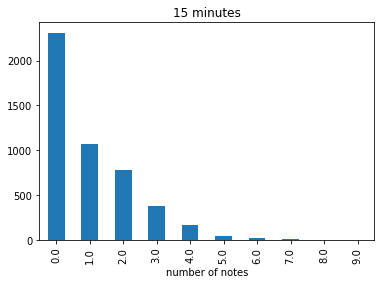

In [52]:
notes_counts_table['15 minutes'].value_counts().plot.bar(title = '15 minutes')
plt.xlabel('number of notes')

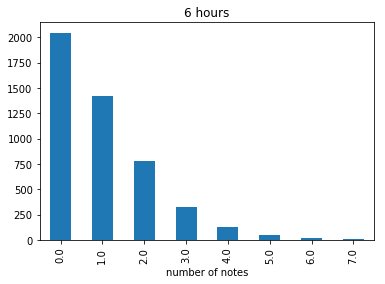

In [53]:
notes_counts_table['6 hours'].value_counts().plot.bar(title = '6 hours')
plt.xlabel('number of notes')


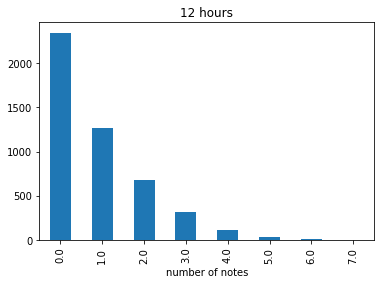

In [54]:
notes_counts_table['12 hours'].value_counts().plot.bar(title = '12 hours')
plt.xlabel('number of notes')


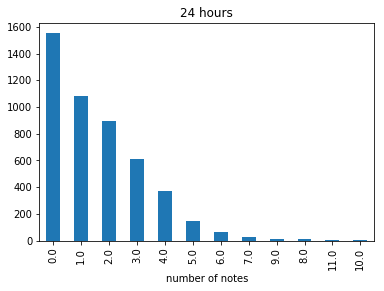

In [55]:
notes_counts_table['24 hours'].value_counts().plot.bar(title = '24 hours')
plt.xlabel('number of notes')




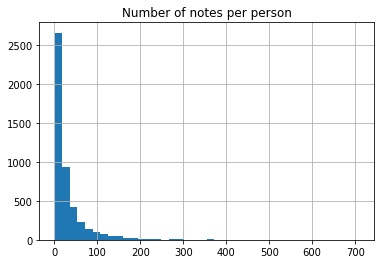

In [69]:
notes_counts_table.sum(1).hist(bins = 40)
plt.title('Number of notes per person')

In [73]:
'Number of subjects with less than 3 notes:', sum(notes_counts_table.sum(1) < 3)

('Number of subjects with less than 3 notes:', 331)

In [118]:
'NUmber of subjects : ', len(notes_counts_table)

('NUmber of subjects : ', 4769)

In [116]:
print('Number of notes:')
notes_counts_table.sum(0)

Number of notes:


15 minutes            4825.0
6 hours               4890.0
12 hours              4292.0
24 hours              7658.0
Over 24 hours       126689.0
SUBJECT_ID       156360600.0
dtype: float64

In [117]:
print('Number of patients:')
(notes_counts_table>0).sum(0)

Number of patients:


15 minutes       2460
6 hours          2726
12 hours         2426
24 hours         3218
Over 24 hours    3994
SUBJECT_ID       4769
dtype: int64

In [109]:
notes_counts_table['SUBJECT_ID'] = notes_counts_table.index

In [76]:
4769/33746

0.14132045279440525

In [14]:
valid_subject['DEATHTIME']= [parser.parse(x) if type(x)!=float else x for x in valid_subject['DEATHTIME']]
valid_subject['DEATHTIME'] = pd.to_datetime(valid_subject['DEATHTIME'])

In [23]:
for sub in valid_subject['SUBJECT_ID']:
    sub_time_dictionary[sub]['DEATHTIME'] = np.array(valid_subject[valid_subject['SUBJECT_ID'] == sub]['DEATHTIME'])

In [8]:
with open('data/patient_timesheet.pickle', 'rb') as handle:
     sub_time_dictionary = pickle.load(handle)

In [32]:
valid_sub_final = set(sub_time_dictionary.keys()) & set(valid_subject['SUBJECT_ID']) 

In [33]:
sub_time_dictionary_final = {}
for sub in valid_sub_final:
    sub_time_dictionary_final[sub] = sub_time_dictionary[sub]

In [34]:
sub_time_dictionary_final

{8193: {'ADMITTIME': array(['2191-07-07T07:52:00.000000000'], dtype='datetime64[ns]'),
  'CHARTTIME': array(['2191-07-14T13:33:00.000000000', '2191-07-07T05:10:00.000000000',
         '2191-07-08T12:16:00.000000000', '2191-07-13T11:11:00.000000000',
         '2191-08-05T17:01:00.000000000', '2191-07-29T08:26:00.000000000',
         '2191-07-31T09:31:00.000000000', '2191-08-02T13:19:00.000000000',
         '2191-08-01T22:32:00.000000000', '2191-08-13T16:44:00.000000000',
         '2191-08-06T22:09:00.000000000', '2191-07-24T08:50:00.000000000',
         '2191-07-23T13:53:00.000000000', '2191-07-26T15:48:00.000000000',
         '2191-07-19T08:31:00.000000000', '2191-07-09T09:08:00.000000000',
         '2191-07-11T12:35:00.000000000', '2191-07-16T04:29:00.000000000',
         '2191-07-16T17:29:00.000000000', '2191-07-21T03:20:00.000000000',
         '2191-07-07T10:32:00.000000000', '2191-07-24T18:29:00.000000000',
         '2191-07-07T17:08:00.000000000', '2191-07-27T04:43:00.000000000',


In [77]:
with open('data/patient_timesheet_final.pickle', 'wb') as handle:
    pickle.dump(sub_time_dictionary_final, handle)
        

In [44]:
for sub in valid_sub_final:
    sub_time_dictionary_final[sub]['CHARTTIME_valid'] = [x for x in sub_time_dictionary_final[sub]['CHARTTIME'] 
                                                   if x < sub_time_dictionary_final[sub]['DISCHTIME']]
    
error_sub = []
for sub in valid_sub_final:
    try:
        sub_time_dictionary_final[sub]['CHARTTIME_interval'] = (sub_time_dictionary_final[sub]['CHARTTIME_valid'] - 
                                                          sub_time_dictionary_final[sub]['ADMITTIME']).astype('timedelta64[m]')
    except TypeError:
        #print(sub)
        error_sub.append(sub)

In [88]:
notes_table_useful = notes_table_useful[~pd.isnull(notes_table_useful['CHARTTIME'])]

In [85]:
sub_for_table = []
charttime_for_table = []
for sub in sub_time_dictionary_final:
    for charttime in sub_time_dictionary_final[sub]['CHARTTIME']:
        notes_table_useful[notes_table_useful['SUBJECT_ID'] == sub][notes_table_useful['CHARTTIME'] == charttime]['TEXT']
        

KeyError: 'CHARTTIME'

In [95]:
documents = list(notes_table_useful['TEXT'])

In [91]:
def find_unique_identification(documents):
    '''
    final all unique identification 

    Returns:
       A list of unique identications
    '''
    identifications = []
    for note in documents:
        i = 0
        while i <len(note):
            if note[i] == '[' and note[i+1] == '*':
                j = i+1
                while note[j-1] != '*' or note[j] != ']':
                    j+=1
                identifications.append(note[i:j+1])
            i+=1
    return list(set(identifications))

In [103]:
unique_iden = find_unique_identification(documents)

In [124]:
len(unique_iden)

156904

In [126]:
sorted(unique_iden)[1000:2000]